In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats

In [51]:
class Employee:
    def __init__(self, level, leave_rate, new_employee):
        # There are 4 possible levels: E, S, M, J
        if level in ['E', 'S', 'M', 'J']:
            self.level = level
        else:
            print("The level of teh employees must be E/S/M/J.")
        # Define the lamada of the employee
        self.leave_rate = leave_rate
        self.new_employee = new_employee
        self.seniority = None   # The time that a employee stays in the company
        self.time_at_level = None   # The time that a employee is at a certain level
        self.generate_seniority()
        self.time_until_depart = self.time_to_depart()

    def time_to_depart(self):
        # Generate a time to departure based on exponential distribution
        return np.random.exponential(1 / self.leave_rate)

    def generate_seniority(self):
        if self.new_employee == None:
            # We assume that the seniority at the beginning is a uniform and mixed value for different level
            seniority_base = {'E': 10, 'S': 5, 'M': 3, 'J': 1}
            seniority = np.random.uniform(seniority_base[self.level]-1, seniority_base[self.level]+1)
            self.seniority = seniority
            self.time_at_level = seniority
        else:
            new_employee_seniority_base = {'E': 0, 'S': 0, 'M': 0, 'J': 0}
            new_employee_seniority = np.random.uniform(0, new_employee_seniority_base[self.level])
            self.seniority = new_employee_seniority
            self.time_at_level = new_employee_seniority

    # Function for resetting employees' time at their level when they are promoted
    def reset_time_at_level(self):
        self.time_at_level = 0

class MaleEmployee(Employee):
    def __init__(self, level, leave_rate, new_employee):
        super().__init__(level, leave_rate, new_employee)


class FemaleEmployee(Employee):
    # Female have an additional timer kappa
    def __init__(self, level, leave_rate, kappa_rate, new_employee):
        self.kappa_rate = kappa_rate
        super().__init__(level, leave_rate, new_employee)

    def time_to_depart(self):
        # Generate a time to departure with additional factor for female employees
        female_leave_time = np.random.exponential(1 / (self.leave_rate + self.kappa_rate))
        return female_leave_time


class Company:
    def __init__(self, employee_profile, lambda_rate_set, kappa_rate_set, gamma, alpha):
        self.employees = {'E': [], 'S': [], 'M': [], 'J': []}
        # The profile is how many people in each of the level
        self.employee_profile = employee_profile
        self.lambda_rate_set = lambda_rate_set
        self.kappa_rate_set = kappa_rate_set
        self.gamma = gamma
        self.alpha = alpha
        # Additional attributes for tracking
        self.time = 0
        # Check how many people leave/retire
        self.vacancies = {'E': 0, 'S': 0, 'M': 0, 'J': 0}
        self.stats_tracker = StatisticsTracker()


    def lower_level(self, level):
        # This function returns the next lower level in the hierarchy
        levels = {'E': 'S', 'S': 'M', 'M': 'J'}
        return levels.get(level, None)  # Returns None if there is no lower level

    def update_seniority(self):
        """ Function for updating seniority."""
        # Increment the seniority of each employee by one unit of time
        for level in ['E', 'S', 'M', 'J']:
            for employee in self.employees[level]:
                employee.seniority += 1
                employee.time_at_level += 1

    def check_retirements(self):
        """Iterate through each level and employee to check for retirements."""
        for level in ['E', 'S', 'M', 'J']:
            for employee in self.employees[level]:
                employee.time_until_depart -= 1
                if employee.time_until_depart <= 0:
                    self.employees[level].remove(employee)
                    self.vacancies[level] += 1

    def promote_employee(self, employee, new_level, old_level):
        """Promote an employee to a new level."""
        self.employees[old_level].remove(employee)
        employee.level = new_level   # Update the employee's level
        employee.reset_time_at_level()
        self.employees[new_level].append(employee)
        self.vacancies[new_level] -= 1
        self.vacancies[old_level] += 1  # New vacancy in the lower level


    def promotions_seniority(self):
        """Promotions strictly based on seniority without bias."""
        # Promote employees based on vacancies starting from the top level
        # J does not consider
        for level in ['E', 'S', 'M']:
            lower_level = self.lower_level(level)
            # if there is vacancy, and there is enough employees in junior level
            while self.vacancies[level] > 0 and self.employees[lower_level]:
                # Find the most senior employee in the next lower level
                most_senior = max(self.employees[lower_level], key=lambda e: e.seniority)
                
                self.promote_employee(most_senior, level, lower_level)

    def promotions_with_bias(self):
        """Promotions with bias towards seniority and gender."""
        for level in ['E', 'S', 'M']:
            lower_level = self.lower_level(level)
            while self.vacancies[level] > 0 and len(self.employees[lower_level]) >= 3:
                # Get the three most senior candidates
                candidates = sorted(self.employees[lower_level], 
                                    key=lambda e: e.time_at_level, reverse=True)[:3]
                probabilities = []
                for e in candidates:
                    bias_factor = self.alpha if isinstance(e, MaleEmployee) else 0
                    # Calculate promotion probabilities
                    promotion_probability = np.exp(self.gamma * e.time_at_level + bias_factor)
                    # print(e, promotion_probability)
                    probabilities.append(promotion_probability)
                    # print(probabilities)
                total_prob = sum(probabilities)

                # Choose a candidate based on probabilities
                chosen_candidate = np.random.choice(candidates, p=[p/total_prob for p in probabilities])

                self.promote_employee(chosen_candidate, level, lower_level)
    
    def promotions_with_quotas(self, quota):
        """Promotions with fixed quotas for each gender."""
        for level in ['E', 'S', 'M']:
            while self.vacancies[level] > 0:
                lower_level = self.lower_level(level)
                if len(self.employees[lower_level]) < quota * 2:
                    break  # Not enough employees to satisfy the quota for both genders

                # Select the most senior employees of each gender
                male_candidates = [e for e in self.employees[lower_level] if isinstance(e, MaleEmployee)]
                female_candidates = [e for e in self.employees[lower_level] if isinstance(e, FemaleEmployee)]

                if male_candidates and female_candidates:
                    # Ensure the quota is met for both genders
                    for _ in range(quota):
                        if self.vacancies[level] == 0:
                            break
                        for candidates in [male_candidates, female_candidates]:
                            most_senior = max(candidates, key=lambda e: e.seniority)
                            self.promote_employee(most_senior, level, lower_level)

    def promotions_with_rooney_rule(self):
        """Promotions with the 'Rooney rule', requiring at least one candidate of each gender."""
        for level in ['E', 'S', 'M']:
            while self.vacancies[level] > 0:
                lower_level = self.lower_level(level)
                if len(self.employees[lower_level]) < 2:
                    break

                # Filter candidates by gender
                male_candidates = [e for e in self.employees[lower_level] if isinstance(e, MaleEmployee)]
                female_candidates = [e for e in self.employees[lower_level] if isinstance(e, FemaleEmployee)]

                if male_candidates and female_candidates:
                    # Choose one candidate from each gender
                    candidates = [max(male_candidates, key=lambda e: e.seniority), 
                                max(female_candidates, key=lambda e: e.seniority)]

                    # Choose a candidate based on seniority
                    chosen_candidate = max(candidates, key=lambda e: e.seniority)
                    self.promote_employee(chosen_candidate, level, lower_level)


    

    def hire_new_employees(self):
        """Hire new employees to fill junior-level vacancies."""
        while self.vacancies['J'] > 0:
            gender = np.random.choice(['male', 'female'])
            new_employee = MaleEmployee('J', self.lambda_rate_set['J'], new_employee=True) if gender == 'male' \
                else FemaleEmployee('J', self.lambda_rate_set['J'], self.kappa_rate_set['J'], new_employee=True)
            self.employees['J'].append(new_employee)
            self.vacancies['J'] -= 1

    def get_gender_ratios(self):
        """Calculate and return the gender ratios at each level."""
        gender_ratios = {}
        for level in ['E', 'S', 'M', 'J']:
            male_count = sum(1 for e in self.employees[level] if isinstance(e, MaleEmployee))
            female_count = sum(1 for e in self.employees[level] if isinstance(e, FemaleEmployee))
            total_count = male_count + female_count
            gender_ratios[level] = {'male': male_count / total_count,
                                    'female': female_count / total_count} if total_count else {'male': 0, 'female': 0}
        return gender_ratios
    
    # Function to calculate the relaxation time
    def calculate_relaxation_time(self, gender_ratios, thresholds, consistency_requirement=33):
        tau_R = {level: None for level in gender_ratios}
        for level in gender_ratios:
            # Retrieve the specified threshold for the current level 
            threshold = thresholds[level]
            consistent_below_threshold = 0

            for i in range(1, len(gender_ratios[level])):
                rate_of_change = abs(gender_ratios[level][i] - gender_ratios[level][i - 1])
                
                if rate_of_change < threshold:
                    consistent_below_threshold += 1
                    # If the counter reaches the required consistency, record the time step
                    if consistent_below_threshold == consistency_requirement:
                        tau_R[level] = i - consistency_requirement + 1
                        break
                else:
                    consistent_below_threshold = 0

        return tau_R
    
    def run_simulation(self, duration, bias):
        # Data storage for plotting
        time_steps = [self.time]       # time_steps = [0]
        # gender_ratios = {'E': [self.get_gender_ratios()['E']['female']],
        #                  'S': [self.get_gender_ratios()['S']['female']],
        #                  'M': [self.get_gender_ratios()['M']['female']],
        #                  'J': [self.get_gender_ratios()['J']['female']]}

        gender_ratios = {'E': [], 'S': [], 'M': [], 'J': []}

        for _ in range(duration):
            if bias == None:
                self.simulate_year()
            else:
                self.simulate_year_bias()

            self.stats_tracker.update_statistics(self)
            time_steps.append(self.time)

            # Get current gender ratios
            for level in gender_ratios:
                gender_ratios[level].append(self.stats_tracker.data[level]['female_gender_ratio'][-1])

        return gender_ratios, self.stats_tracker.calculate_metrics()

    # No bias
    def simulate_year(self):
        """Simulate a year in the company, including retirements, promotions, and hiring."""
        self.time += 1
        # update seniority function
        self.update_seniority()
        self.check_retirements()
        self.promotions_seniority()
        self.hire_new_employees()
    
    # With bias
    def simulate_year_bias(self):
        self.time += 1
        self.update_seniority()
        self.check_retirements()
        self.promotions_with_bias()
        self.hire_new_employees()

class Company_All(Company):
    def __init__(self, employee_profile, lambda_rate_set, kappa_rate_set,  gamma, alpha, gender):
        super().__init__(employee_profile, lambda_rate_set, kappa_rate_set, gamma, alpha)
        self.gender = gender
        self.initialize_employees()  # Adjust this method for different initial states

    def initialize_employees(self):
        for level in self.employees:
            for _ in range(self.employee_profile[level]):
                if self.gender =='Male':
                    initial_employee = MaleEmployee(level, self.lambda_rate_set[level], new_employee=None)
                elif self.gender == 'Female':
                    initial_employee = FemaleEmployee(level, self.lambda_rate_set[level], self.kappa_rate_set[level], new_employee=None)
                else:
                    # Mixed - Equally likely 
                    self.gender = np.random.choice(['male', 'female'])
                    initial_employee = MaleEmployee(level, self.lambda_rate_set[level], new_employee=None) if self.gender == 'male' \
                    else FemaleEmployee(level, self.lambda_rate_set[level], self.kappa_rate_set[level], new_employee=None)
                self.employees[level].append(initial_employee)

    def plot_gender_ratios(self, time_steps, gender_ratios, gamma, alpha):
        plt.figure(figsize=(10, 6))
        for level in gender_ratios:
            plt.plot(time_steps[:len(gender_ratios[level])], gender_ratios[level], label=f'Level {level}')
        
        plt.xlabel('Time (Years)')
        plt.ylabel('Female Gender Ratio')
        if self.gender == 'Male':
            plt.title('Gender Ratio Trends Over Time by Level, Under All Male Initial')
        elif self.gender == 'Female':
            plt.title('Gender Ratio Trends Over Time by Level, Under All Female Initial')
        else:
            plt.title(f'Gender Ratio Trends Over Time by Level, Mixed, γ={gamma}, α={round(alpha, 3)}')

        plt.legend()
        plt.grid()
        plt.show()

class StatisticsTracker:
    def __init__(self):
        # Initialize dictionaries to store data for each level and metric
        self.data = {'E': {'female_gender_ratio': []},
                     'S': {'female_gender_ratio': []},
                     'M': {'female_gender_ratio': []},
                     'J': {'female_gender_ratio': []}}
        
        # self.data = {'E': {'seniority': [], 'female_gender_ratio': []},
        #              'S': {'seniority': [], 'female_gender_ratio': []},
        #              'M': {'seniority': [], 'female_gender_ratio': []},
        #              'J': {'seniority': [], 'female_gender_ratio': []}}

        # self.data = {'E': {'female_gender_ratio': [], 'seniority': [], 'time_at_level': []},
        #              'S': {'female_gender_ratio': [], 'seniority': [], 'time_at_level': []},
        #              'M': {'female_gender_ratio': [], 'seniority': [], 'time_at_level': []},
        #              'J': {'female_gender_ratio': [], 'seniority': [], 'time_at_level': []}}

    def update_statistics(self, company_state):
        """Update statistics based on the current state of the company."""
        for level in company_state.employees:
            male_count, female_count, total_seniority, total_time_at_level= 0, 0, 0, 0
            for employee in company_state.employees[level]:
                total_seniority += employee.seniority
                total_time_at_level += employee.time_at_level
                if isinstance(employee, MaleEmployee):
                    male_count += 1
                elif isinstance(employee, FemaleEmployee):
                    female_count += 1
            total_count = male_count + female_count

            # Calculate the average gender (seniority, time_at_level)
            gender_ratio = female_count / total_count if total_count != 0 else 0
            avg_seniority = total_seniority / total_count if total_count != 0 else 0
            avg_time_at_level = total_time_at_level / total_count if total_count != 0 else 0
            self.data[level]['female_gender_ratio'].append(gender_ratio)
            # self.data[level]['seniority'].append(avg_seniority)
            # self.data[level]['time_at_level'].append(avg_time_at_level)

    def calculate_metrics(self):
        """Calculate and return key metrics for each level."""
        metrics = {}
        for level in self.data:
            metrics[level] = {}
            for metric in self.data[level]:
                values = self.data[level][metric]
                mean = np.mean(values)
                ci = [mean - stats.sem(values) * 1.96, mean + stats.sem(values) * 1.96]   # 95% CI
                metrics[level][metric] = {'mean': mean, '95% CI': ci}

        # Create a dataframe to store the metrics
        transformed_data = []
        for level, metrics_dict in metrics.items():
            for metric, values in metrics_dict.items():
                row = {
                    'Level': level,
                    'Metric': metric,
                    'Mean': values['mean'],
                    '95% CI Lower': values['95% CI'][0],
                    '95% CI Upper': values['95% CI'][1]
                }
                transformed_data.append(row)

        metrics_df = pd.DataFrame(transformed_data)
        return metrics_df

class SimulationRunner:
    def __init__(self, company_class, employee_profile, lambda_rate_set, kappa_rate_set, gamma, alpha, gender):
        self.company_class = company_class
        self.employee_profile = employee_profile
        self.lambda_rate_set = lambda_rate_set
        self.kappa_rate_set = kappa_rate_set
        self.gamma = gamma
        self.alpha = alpha
        self.gender = gender

    def run_single_simulation(self, duration, bias):
        """Run a single simulation for the given duration."""
        company = self.company_class(self.employee_profile, self.lambda_rate_set, self.kappa_rate_set, self.gamma, self.alpha, self.gender)
        company.run_simulation(duration, bias)
        return company.stats_tracker.data

    def run_multiple_simulations(self, num_simulations, duration, bias):
        all_simulation_data = []
        for _ in range(num_simulations):
            simulation_data = self.run_single_simulation(duration, bias)
            all_simulation_data.append(simulation_data)
        return all_simulation_data

    def calculate_average_and_ci(self, simulation_data):
        """Calculate average and 95% CI for each metric across all simulations."""
        avg_data = {level: {'female_gender_ratio': {'mean': [], 'ci': []}} for level in ['E', 'S', 'M', 'J']}
        for level in avg_data:
            for time_step in range(len(simulation_data[0][level]['female_gender_ratio'])):
                time_step_data = [sim[level]['female_gender_ratio'][time_step] for sim in simulation_data]
                mean = np.mean(time_step_data)
                ci = stats.sem(time_step_data) * stats.t.ppf((1 + 0.95) / 2., len(time_step_data)-1)
                avg_data[level]['female_gender_ratio']['mean'].append(mean)
                avg_data[level]['female_gender_ratio']['ci'].append(ci)
        return avg_data

    def plot_average_ci(self, avg_data):
        """Plot the average results with confidence intervals."""
        plt.figure(figsize=(10, 6))
        time_steps = range(len(avg_data['E']['female_gender_ratio']['mean']))

        # Plot average and CI
        for level in avg_data:
            means = avg_data[level]['female_gender_ratio']['mean']
            cis = avg_data[level]['female_gender_ratio']['ci']
            plt.fill_between(time_steps, [m - c for m, c in zip(means, cis)], [m + c for m, c in zip(means, cis)], alpha=0.2)
            plt.plot(time_steps, means, label=f'{level} Average')

        plt.xlabel('Time (Years)')
        plt.ylabel('Fraction of Women')
        plt.title('Expected value and 95% CIs of Gender Ratio Over Time by Level')
        plt.grid()
        plt.legend()
        plt.show()


    def plot_sample_path(self, avg_data, sample_paths=None):
        """Plot sample paths."""
        time_steps = range(len(avg_data['E']['female_gender_ratio']['mean']))

        # Determine the number of rows/columns for the subplot grid
        n_levels = len(avg_data)
        nrows = int(np.sqrt(n_levels))
        ncols = int(np.ceil(n_levels / nrows))

        # Create a figure with subplots
        fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), sharex=True, sharey=True)
        axes = axes.flatten()  # Flatten the axes array for easy iteration

        # Plot sample paths in subplots
        for i, (level, ax) in enumerate(zip(avg_data, axes)):
            if sample_paths:
                for j, path in enumerate(sample_paths):
                    ax.plot(time_steps, path[level]['female_gender_ratio'], label=f'Sample {j+1}', alpha=0.7)

            ax.set_xlabel('Time (Years)')
            ax.set_ylabel('Fraction of Women')
            ax.set_title(f'Level {level}')
            ax.grid(True)
            if i == 0:  # Only add a legend to the first subplot for clarity
                ax.legend()

        # Adjust layout to prevent overlap and show the plot
        plt.tight_layout()
        plt.show()

# 1. Simulation Models under Three Different Initial States

In this part, we will promote employees strictly based on seniority without any bias.

We base our model on the assumption that younger employees tend to leave their positions more frequently than their senior counterparts. This is reflected in our setting of the λ values, where junior-level employees have a higher rate of departure. Specifically, our λ values are set in an ascending order from executive to junior levels—$\frac{1}{5}$ for executives (E), $\frac{1}{4}$ for senior management (S), $\frac{1}{3}$ for management (M), and $\frac{1}{x}$ for junior employees (J).

Additionally, we assume that female employees leave 15% earlier than male employees. For example, if a junior male employee is expected to leave in 2 years (λ = $\frac{1}{2}$), a female employee in the same position would leave in $2\times(1-15\%)=1.7$ years. This is modeled by adjusting the departure rate for female employees to  $\frac{1}{1.7}$, leading to a calculated κ value of  $\frac{1}{1.7}$ -  $\frac{1}{2}$ for junior-level female employees. Consequently, the κ values for each level are derived using this methodology, resulting in differentially calculated rates that capture the additional departure likelihood for female employees across all levels.

In [6]:
# Parameters
target_employees = {'E': 5, 'S': 20, 'M': 100, 'J': 400}
lambda_rate_set_user = {'E': 1/5, 'S': 1/4, 'M': 1/3, 'J': 1/2}
kappa_rate_set_user = {'E': 1/(5*0.85) - 1/5, 'S': 1/(4*0.85) - 1/4, 'M': 1/(3*0.85) - 1/3, 'J': 1/(2*0.85) - 1/2}
gamma = None    # Preference for seniority
alpha = None    # Bias towards selecting male candidates (can be +/-)
# Define the duration (in years) to simulate 
n_years = 100
# Define the thresholds to calculate the relaxation time
thresholds = {'E': 0.4, 'S': 0.3, 'M': 0.15, 'J': 0.05}

## 1.1 Initial States: All Male Employees

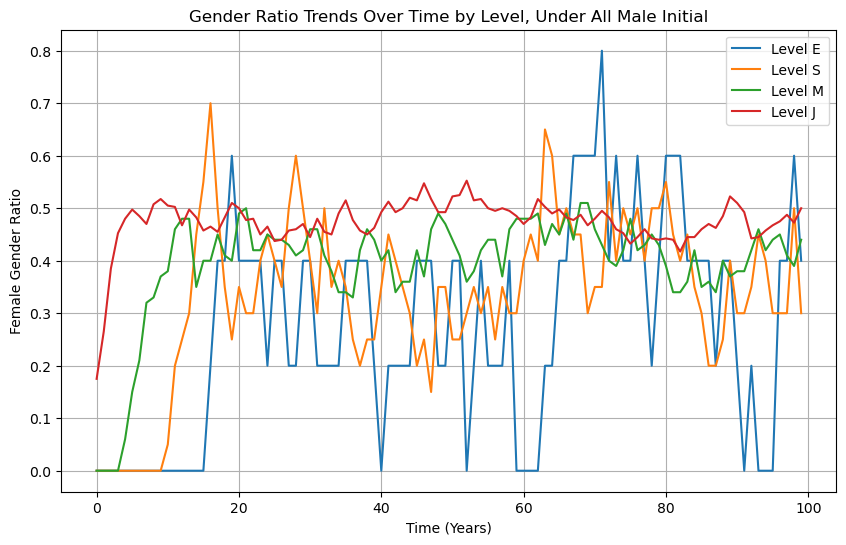

  Level               Metric     Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.27200      0.232008      0.311992
1     S  female_gender_ratio  0.33350      0.302949      0.364051
2     M  female_gender_ratio  0.39320      0.372666      0.413734
3     J  female_gender_ratio  0.47375      0.464616      0.482884
(All Male) Relaxation times for each level : {'E': 1, 'S': 1, 'M': 1, 'J': 4}


In [7]:
np.random.seed(1)
company_male = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Male')
# Run the simulation for a given duration
gender_ratios, metrics = company_male.run_simulation(duration=n_years, bias=None)
tau_R_all_male = company_male.calculate_relaxation_time(gender_ratios, thresholds)

# Plot the results
company_male.plot_gender_ratios(np.arange(n_years + 1), gender_ratios, gamma, alpha)
# Print the results
print(metrics)
print("(All Male) Relaxation times for each level :", tau_R_all_male)

## 1.2 Initial States: All Female Employees

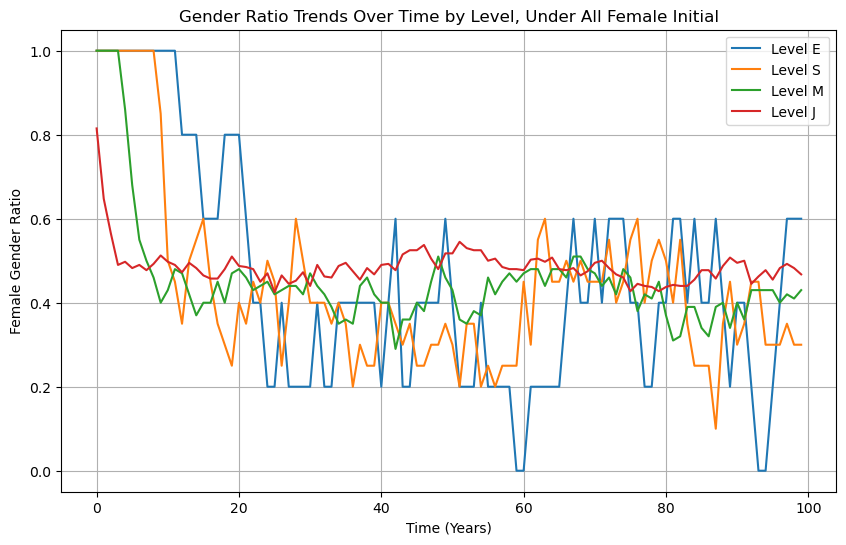

  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.460000      0.406414      0.513586
1     S  female_gender_ratio  0.440500      0.399187      0.481813
2     M  female_gender_ratio  0.452900      0.427017      0.478783
3     J  female_gender_ratio  0.486175      0.477202      0.495148
(All Female) Relaxation times for each level : {'E': 1, 'S': 11, 'M': 6, 'J': 4}


In [8]:
np.random.seed(1)
company_female = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Female')
gender_ratios, metrics = company_female.run_simulation(duration=n_years, bias=None)
tau_R_all_female = company_female.calculate_relaxation_time(gender_ratios, thresholds)

# Plot the results
company_female.plot_gender_ratios(np.arange(n_years + 1), gender_ratios, gamma, alpha)
# Print the results
print(metrics)
print("(All Female) Relaxation times for each level :", tau_R_all_female)

## 1.3 Initial State: 50% Male Employees and 50% Female Employees

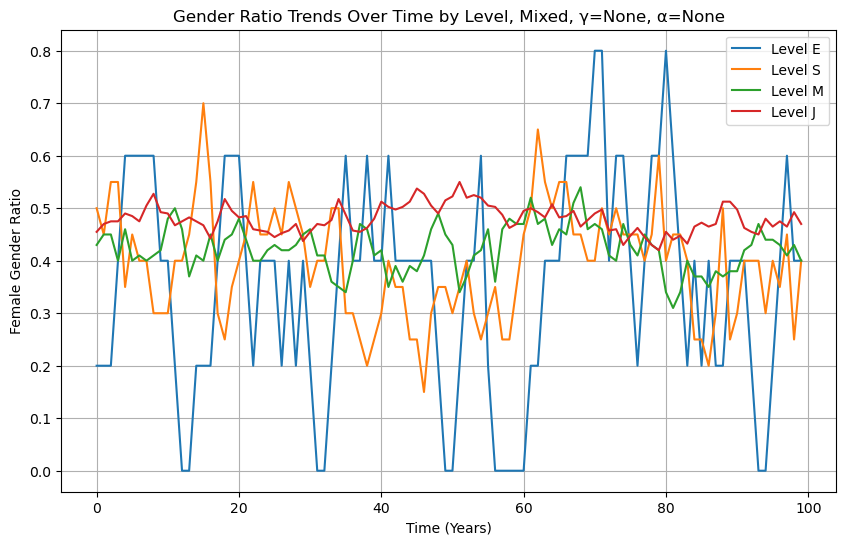

  Level               Metric     Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.35600      0.315599      0.396401
1     S  female_gender_ratio  0.39650      0.375641      0.417359
2     M  female_gender_ratio  0.42250      0.413907      0.431093
3     J  female_gender_ratio  0.47945      0.474338      0.484562
(Half M Half F) Relaxation times for each level : {'E': 1, 'S': 1, 'M': 1, 'J': 1}


In [9]:
np.random.seed(1)
company_mixed = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
gender_ratios, metrics = company_mixed.run_simulation(duration=n_years, bias=None)
tau_R_mixed = company_mixed.calculate_relaxation_time(gender_ratios, thresholds)

# Plot the results
company_mixed.plot_gender_ratios(np.arange(n_years + 1), gender_ratios, gamma, alpha)
# Print the results
print(metrics)
print("(Half M Half F) Relaxation times for each level :", tau_R_mixed)

To find a reasonable relaxation times for each level, we will run the simulation 1000 times and then find the average relaxation time for each level across all runs.

In [10]:
total_tau_R = {'E': 0, 'S': 0, 'M': 0, 'J': 0}
count_tau_R = {'E': 0, 'S': 0, 'M': 0, 'J': 0}
num_runs = 1000

for _ in range(num_runs):
    company_mixed = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
    gender_ratios, metrics = company_mixed.run_simulation(duration=n_years, bias=None)
    tau_R_mixed = company_mixed.calculate_relaxation_time(gender_ratios, thresholds)

    # Add the relaxation times from this run to the total, only if they are not None
    for level in total_tau_R:
        if tau_R_mixed[level] is not None:
            total_tau_R[level] += tau_R_mixed[level]
            count_tau_R[level] += 1

average_tau_R = {level: total_tau_R[level] / count_tau_R[level] if count_tau_R[level] > 0 else None for level in total_tau_R}

# Print
print("Average Relaxation Times:", average_tau_R)

Average Relaxation Times: {'E': 15.573333333333334, 'S': 2.543, 'M': 1.261, 'J': 12.45}


# 2. Run 100 Simulations for $5\tau$ Duration without Bias

In [12]:
# Parameters
target_employees = {'E': 5, 'S': 20, 'M': 100, 'J': 400}
lambda_rate_set_user = {'E': 1/5, 'S': 1/4, 'M': 1/3, 'J': 1/2}
kappa_rate_set_user = {'E': 1/(5*0.85) - 1/5, 'S': 1/(4*0.85) - 1/4, 'M': 1/(3*0.85) - 1/3, 'J': 1/(2*0.85) - 1/2}
gamma = None    # Preference for seniority
alpha = None    # Bias towards selecting male candidates (can be +/-)

# Parameters for the simulation
n_simulations = 100
# Calculate the maximum of tau to ensure that the model approaches steady state
tau_R = 5 * math.ceil(max([value for value in average_tau_R.values() if value is not None]))

In [30]:
simulation_runner = SimulationRunner(Company_All, target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
all_simulation_data = simulation_runner.run_multiple_simulations(n_simulations, tau_R, bias=None)

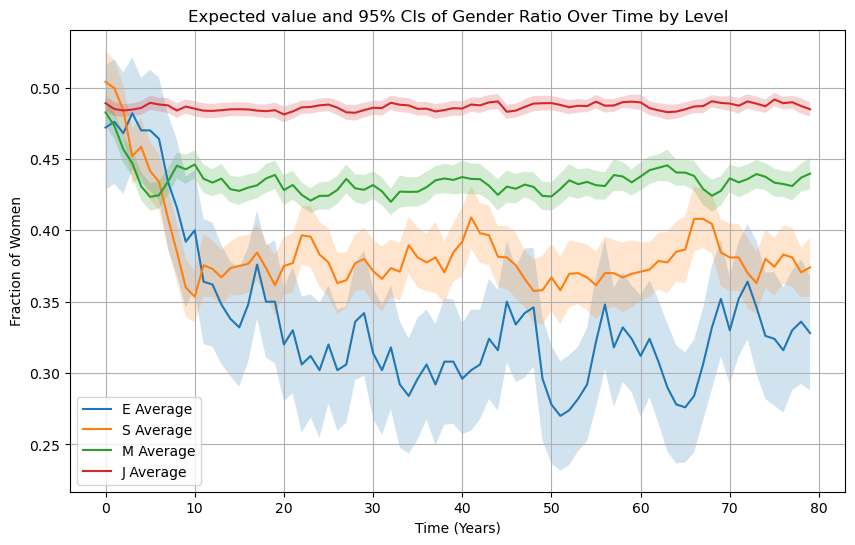

In [31]:
# Calculate average and CI
avg_data = simulation_runner.calculate_average_and_ci(all_simulation_data)
# Plot the average results with confidence intervals
simulation_runner.plot_average_ci(avg_data)

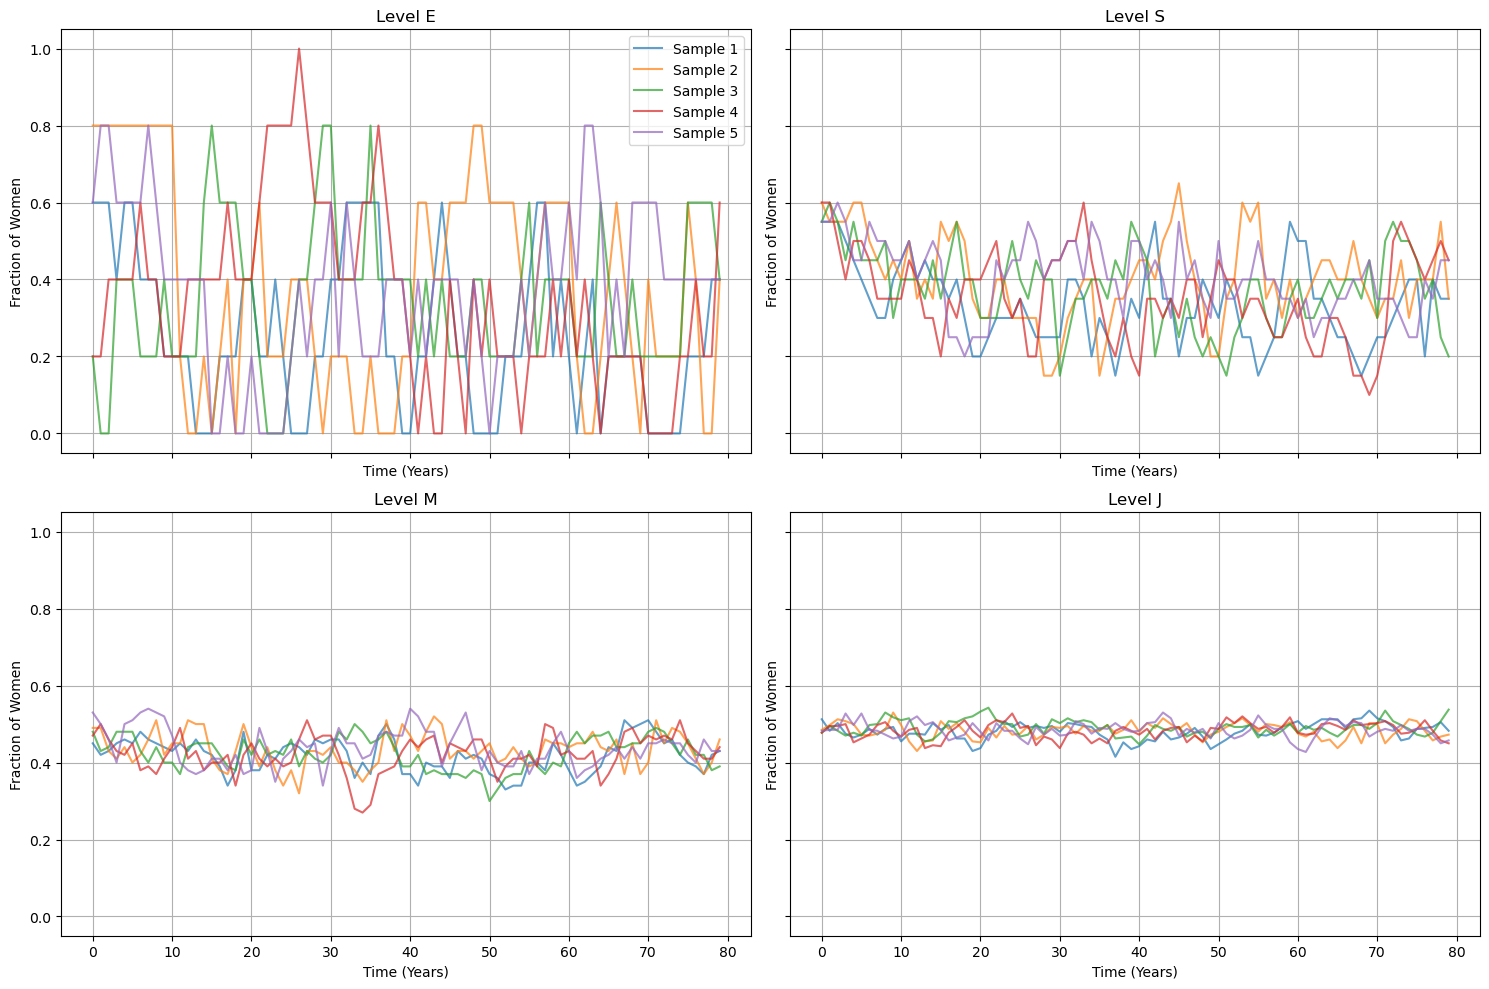

In [32]:
# Plots the first 5 sample paths
sample_paths = all_simulation_data[:5]
simulation_runner.plot_sample_path(avg_data, sample_paths=sample_paths)

# 3. Simulation Model with Bias

In this part, the three seniormost candidates at each level are chosen for promotion with probability proportional to $e^{\gamma T_i+\alpha \mathbb{1}[\text{i is male}]}$, where $\gamma$ represents a preference for seniority and $\alpha$ represents a bias towards selecting male candidates.

To comprehensively assess the influence of varying degrees of bias, we have chosen to simulate scenarios with five distinct levels of bias: 5%, 25%, 50%, 75%, and 95%. Since the value of $\alpha$ determines the likelihood of a male employee being chosen over a female employee for promotion, which expressed as $\frac{e^{\alpha}}{1+e^{\alpha}}$, we can calculate the $\alpha$ by using the formula $ln(\frac{bias}{1-bias})$.

In [33]:
# Parameters
target_employees = {'E': 5, 'S': 20, 'M': 100, 'J': 400}
lambda_rate_set_user = {'E': 1/5, 'S': 1/4, 'M': 1/3, 'J': 1/2}
kappa_rate_set_user = {'E': 1/(5*0.85) - 1/5, 'S': 1/(4*0.85) - 1/4, 'M': 1/(3*0.85) - 1/3, 'J': 1/(2*0.85) - 1/2}
gamma = 1    # Preference for seniority
bias_levels = [0.05, 0.25, 0.50, 0.75, 0.95]
alpha_values = [np.log(bias / (1 - bias)) for bias in bias_levels]    # Bias towards selecting male candidates (can be +/-)
# Define the duration (in years) to simulate 
n_years = tau_R
levels = ['E', 'S', 'M', 'J']

<Figure size 640x480 with 0 Axes>

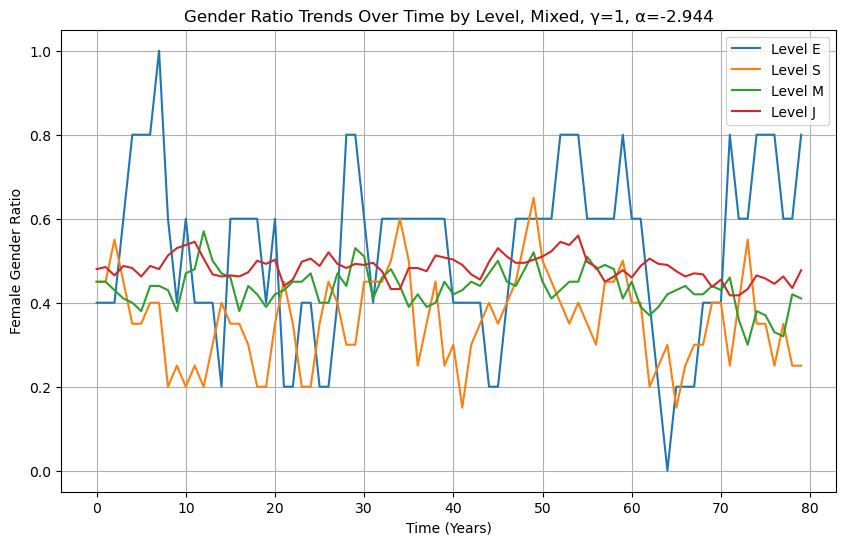

Metrics for alpha = -2.9444389791664403:
  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.525000      0.480690      0.569310
1     S  female_gender_ratio  0.357500      0.334039      0.380961
2     M  female_gender_ratio  0.433875      0.423809      0.443941
3     J  female_gender_ratio  0.483094      0.476640      0.489548


<Figure size 640x480 with 0 Axes>

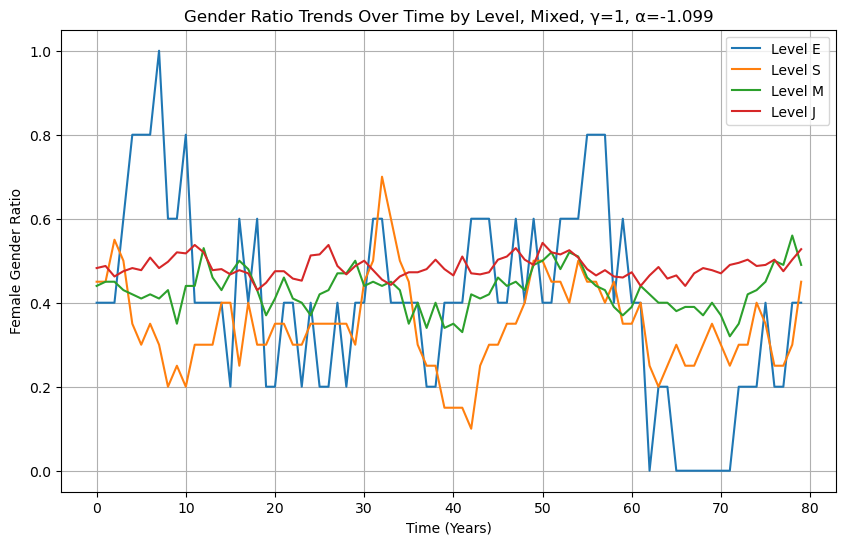

Metrics for alpha = -1.0986122886681098:
  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.402500      0.352948      0.452052
1     S  female_gender_ratio  0.345625      0.322288      0.368962
2     M  female_gender_ratio  0.429000      0.418104      0.439896
3     J  female_gender_ratio  0.484812      0.479466      0.490159


<Figure size 640x480 with 0 Axes>

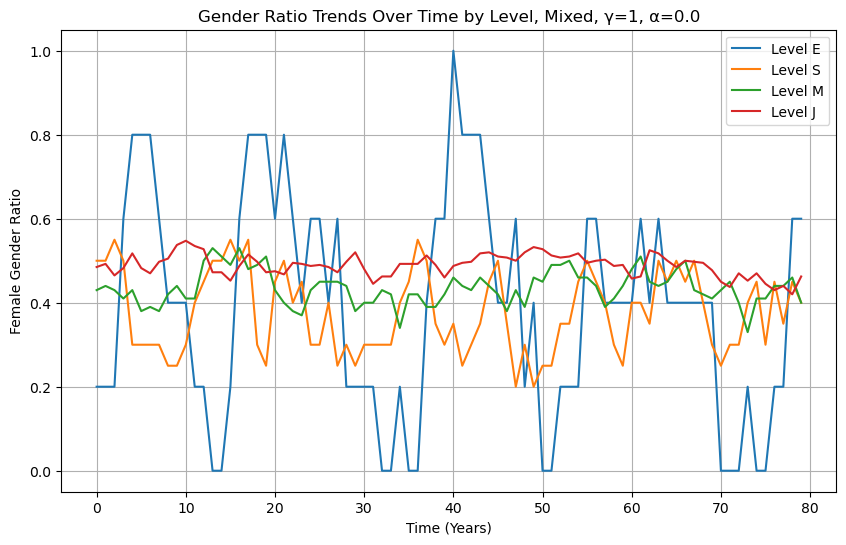

Metrics for alpha = 0.0:
  Level               Metric     Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.39250      0.334809      0.450191
1     S  female_gender_ratio  0.37625      0.355043      0.397457
2     M  female_gender_ratio  0.43500      0.426002      0.443998
3     J  female_gender_ratio  0.48900      0.483230      0.494770


<Figure size 640x480 with 0 Axes>

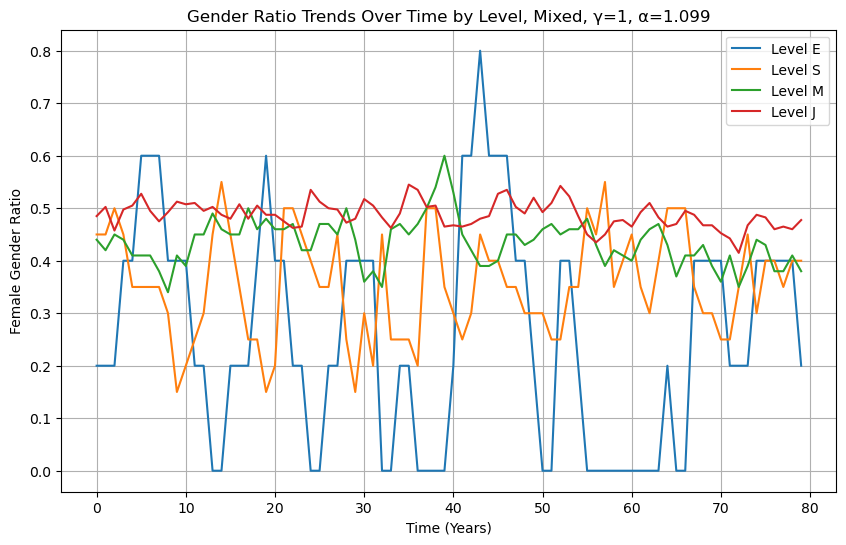

Metrics for alpha = 1.0986122886681098:
  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.257500      0.211670      0.303330
1     S  female_gender_ratio  0.355000      0.333184      0.376816
2     M  female_gender_ratio  0.434375      0.424533      0.444217
3     J  female_gender_ratio  0.487562      0.482050      0.493075


<Figure size 640x480 with 0 Axes>

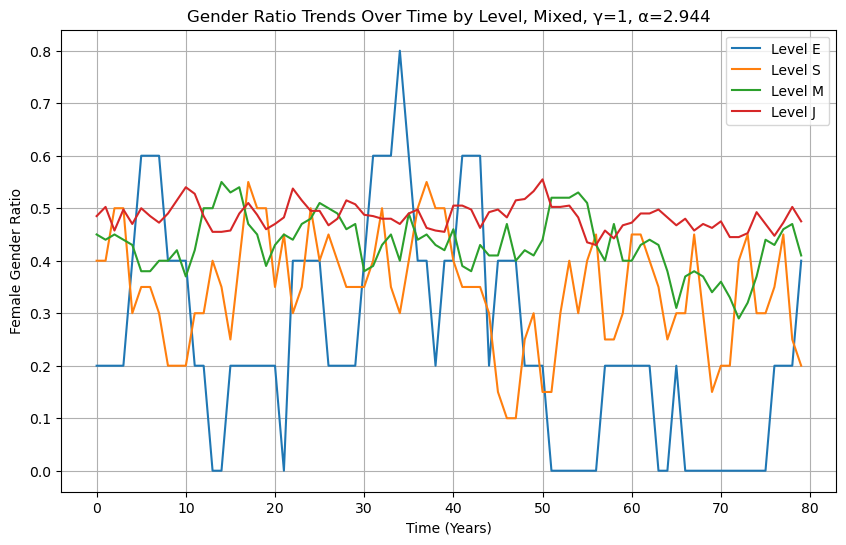

Metrics for alpha = 2.9444389791664394:
  Level               Metric      Mean  95% CI Lower  95% CI Upper
0     E  female_gender_ratio  0.247500      0.202716      0.292284
1     S  female_gender_ratio  0.345000      0.321442      0.368558
2     M  female_gender_ratio  0.431750      0.419804      0.443696
3     J  female_gender_ratio  0.483844      0.478400      0.489288


In [48]:
average_ratios = {level: {alpha: None for alpha in alpha_values} for level in levels}
average_ratios_last_4_tau = {level: {alpha: None for alpha in alpha_values} for level in levels}
for alpha in alpha_values:
    np.random.seed(1)
    company_with_bias = Company_All(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
    gender_ratios, metrics = company_with_bias.run_simulation(duration=n_years, bias=True)
    for level in levels:
        average_ratios[level][alpha] = np.mean(gender_ratios[level])

        start_index = int(n_years / 4)
        average_ratios_last_4_tau[level][alpha] = np.mean(gender_ratios[level][start_index:])

    # Plot the results for each alpha
    plt.figure()
    company_with_bias.plot_gender_ratios(np.arange(n_years + 1), gender_ratios, gamma, alpha)

    # Print the results for each alpha
    print(f"Metrics for alpha = {alpha}:")
    print(metrics)

Level E:
  Alpha -2.944: Average Ratio = 0.5250
  Alpha -1.099: Average Ratio = 0.4025
  Alpha 0.0: Average Ratio = 0.3925
  Alpha 1.099: Average Ratio = 0.2575
  Alpha 2.944: Average Ratio = 0.2475

Level S:
  Alpha -2.944: Average Ratio = 0.3575
  Alpha -1.099: Average Ratio = 0.3456
  Alpha 0.0: Average Ratio = 0.3763
  Alpha 1.099: Average Ratio = 0.3550
  Alpha 2.944: Average Ratio = 0.3450

Level M:
  Alpha -2.944: Average Ratio = 0.4339
  Alpha -1.099: Average Ratio = 0.4290
  Alpha 0.0: Average Ratio = 0.4350
  Alpha 1.099: Average Ratio = 0.4344
  Alpha 2.944: Average Ratio = 0.4317

Level J:
  Alpha -2.944: Average Ratio = 0.4831
  Alpha -1.099: Average Ratio = 0.4848
  Alpha 0.0: Average Ratio = 0.4890
  Alpha 1.099: Average Ratio = 0.4876
  Alpha 2.944: Average Ratio = 0.4838



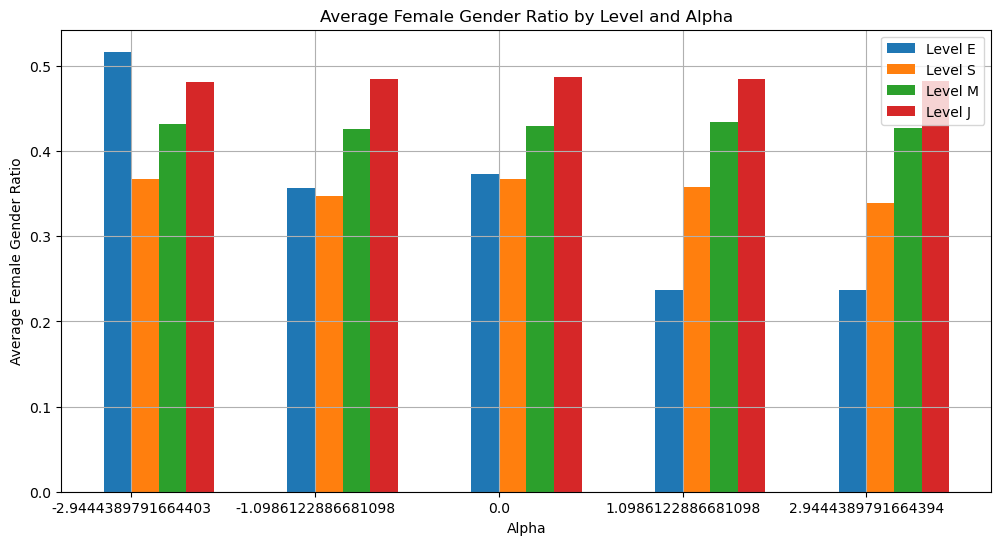

In [49]:
# Plot the average gender ratio by level and alpha in histogram
plt.figure(figsize=(12, 6))

# Parameters for the histogram
n_levels = len(levels)
width = 0.15  # Width of the bars in the histogram

# Create a histogram for each level
for i, level in enumerate(levels):
    # Calculate position of each bar
    positions = np.arange(len(alpha_values)) + i * width
    
    # Heights of the bars (average ratios)
    heights = [average_ratios_last_4_tau[level][alpha] for alpha in alpha_values]
    
    # Plot
    plt.bar(positions, heights, width, label=f'Level {level}')

    # Print
    print(f"Level {level}:")
    for alpha in alpha_values:
        print(f"  Alpha {round(alpha, 3)}: Average Ratio = {average_ratios[level][alpha]:.4f}")
    print()

# Add labels, title, and legend
plt.xlabel('Alpha')
plt.ylabel('Average Female Gender Ratio')
plt.title('Average Female Gender Ratio by Level and Alpha')
plt.xticks(np.arange(len(alpha_values)) + width / 2, alpha_values)
plt.legend()
plt.grid()
plt.show()

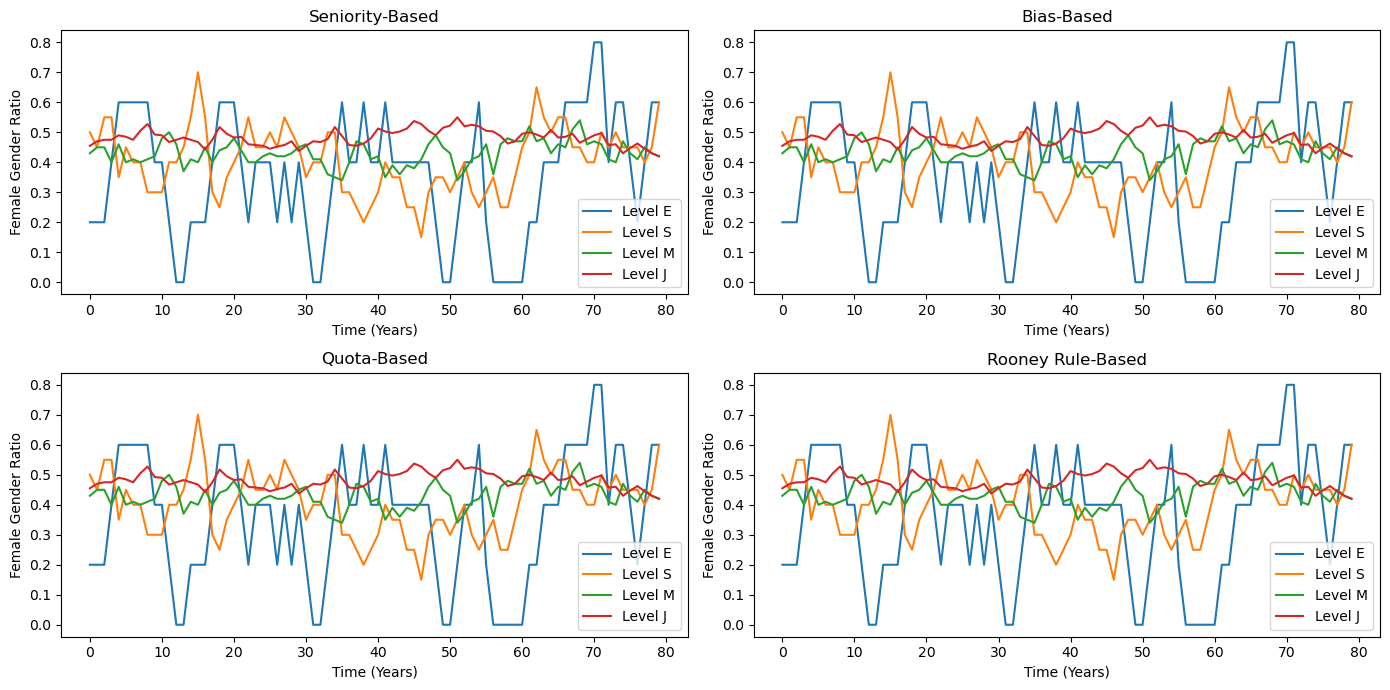

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the Company_All class and all other necessary imports and parameters are already defined

def run_promotion_strategy_simulation(strategy_function, company_class, strategy_args=None):
    np.random.seed(1)  # For reproducibility
    company = company_class(target_employees, lambda_rate_set_user, kappa_rate_set_user, gamma, alpha, 'Mixed')
    gender_ratios = {level: [] for level in levels}
    for _ in range(n_years):
        strategy_function(company, **(strategy_args or {}))
        company.simulate_year()  # Assuming this function runs the yearly simulation
        ratios = company.get_gender_ratios()
        for level in levels:
            gender_ratios[level].append(ratios[level]['female'])
    return gender_ratios

def visualize_promotion_strategies(strategies, company_class):
    plt.figure(figsize=(14, 7))
    for i, (strategy_name, strategy_function, strategy_args) in enumerate(strategies, 1):
        gender_ratios = run_promotion_strategy_simulation(strategy_function, company_class, strategy_args)
        plt.subplot(2, 2, i)
        for level in levels:
            plt.plot(gender_ratios[level], label=f'Level {level}')
        plt.title(strategy_name)
        plt.xlabel('Time (Years)')
        plt.ylabel('Female Gender Ratio')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Define strategies
strategies = [
    ('Seniority-Based', Company_All.promotions_seniority, None),
    ('Bias-Based', Company_All.promotions_with_bias, None),
    ('Quota-Based', Company_All.promotions_with_quotas, {'quota': 1}),
    ('Rooney Rule-Based', Company_All.promotions_with_rooney_rule, None)
]

# Run and visualize
visualize_promotion_strategies(strategies, Company_All)
